# Introduction to 🤗 Diffusers

![diffusers_library](https://github.com/huggingface/diffusers/raw/main/docs/source/en/imgs/diffusers_library.jpg)

이 노트북에서는 **귀여운 나비의 이미지를 생성하는 🦋** 첫 번째 디퓨전 모델을 훈련합니다. 이 과정에서 🤗 디퓨저 라이브러리의 핵심 구성 요소에 대해 배우게 되며, 이는 이 과정의 뒷부분에서 다룰 고급 애플리케이션을 위한 좋은 토대가 될 것입니다.

자세히 알아봅시다!

## What You Will Learn

이 노트북에서 아래의 내용을 배웁니다:

- 강력한 사용자 지정 디퓨전 모델 파이프라인이 실제로 작동하는 모습을 확인하세요(나만의 버전을 만드는 방법에 대한 정보 포함).
- 다음과 같은 방법으로 나만의 미니 파이프라인을 만들 수 있습니다:
  - 확산 모델의 핵심 아이디어 요약하기
  - 학습을 위해 허브에서 데이터 불러오기
  - 스케줄러를 사용하여 이 데이터에 노이즈를 추가하는 방법 살펴보기
  - UNet 모델 생성 및 학습
  - 조각들을 작동하는 파이프라인으로 통합하기
- 더 긴 트레이닝 실행을 초기화하기 위한 스크립트를 편집하고 실행하고 다룰 수 있습니다. 
  - 🤗 가속을 통한 멀티 GPU 트레이닝
  - 중요한 통계를 추적하는 실험 로깅
  - 허깅 페이스 허브에 최종 모델 업로드하기

❓궁금한 점이 있으시면 허깅페이스 디스코드 서버의 `#diffusion-models-class` 채널에 질문글을 올려주세요. 아직 가입하지 않으셨다면 여기에서 가입하실 수 있습니다: https://huggingface.co/join/discord

## Prerequisites

노트북을 살펴보기 전에 먼저 알아두어야 할 사항이 있습니다:

* 📖 단원 1 자료 읽기
* 🤗 Hugging Face Hub에서 계정을 생성합니다. 아직 계정을 만들지 않았다면 여기에서 만들 수 있습니다: https://huggingface.co/join

## Step 1: Setup

다음 셀을 실행하여 디퓨저 라이브러리와 몇 가지 다른 요구 사항을 설치합니다:

In [1]:
%pip install -qq -U diffusers datasets transformers accelerate ftfy pyarrow==9.0.0

Note: you may need to restart the kernel to use updated packages.


그런 다음 https://huggingface.co/settings/tokens 으로 이동하여 쓰기 권한이 있는 액세스 토큰을 생성합니다(아직 없는 경우):

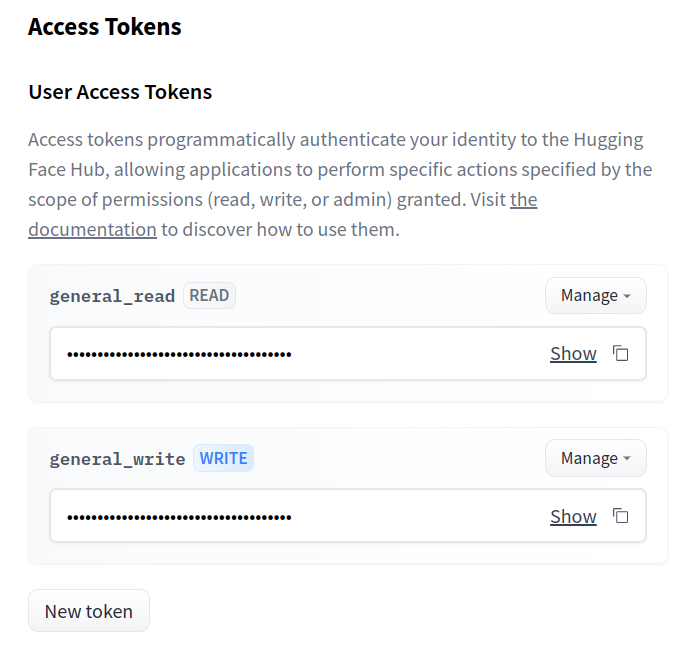

이 토큰으로 로그인하려면 명령줄(`huggingface-cli login`)을 사용하거나 다음 셀을 실행하여 로그인할 수 있습니다:

In [6]:
from huggingface_hub import notebook_login
from huggingface_hub import login

# login('put your available token')
notebook_login()

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid.
Your token has been saved to C:\Users\warm1\.cache\huggingface\token
Login successful


그런 다음 모델 체크포인트를 업로드하려면 Git-LFS를 설치해야 합니다:

In [7]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

마지막으로, 사용할 라이브러리를 가져오고 나중에 노트북에서 사용할 몇 가지 편의 기능을 정의해 보겠습니다:

In [8]:
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image


def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im


# Mac users may need device = 'mps' (untested)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

이제 준비되었습니다!

## Dreambooth: A Sneak Peak at What's to Come

지난 몇 달 동안 AI 관련 소셜 미디어를 조금이라도 보셨다면 스테이블 디퓨전에 대해 들어보셨을 것입니다. 이는 강력한 텍스트 조건부 잠재 디퓨전 모델입니다(이 모든 것이 무엇을 의미하는지 곧 알게 될 테니 걱정하지 마세요). 하지만 결점이 있습니다: 인터넷에 이미지가 도배될 정도로 유명하지 않은 이상 여러분이나 제가 어떻게 생겼는지 알지 못합니다. 

드림부스를 사용하면 특정 얼굴, 사물 또는 스타일에 대한 추가 지식으로 나만의 모델 변형을 만들 수 있습니다. Corridor Crew는 이 기법을 사용하여 일관된 캐릭터로 스토리를 전달하는 훌륭한 동영상을 만들었는데, 이는 이 기법이 무엇을 할 수 있는지를 보여주는 좋은 예입니다:

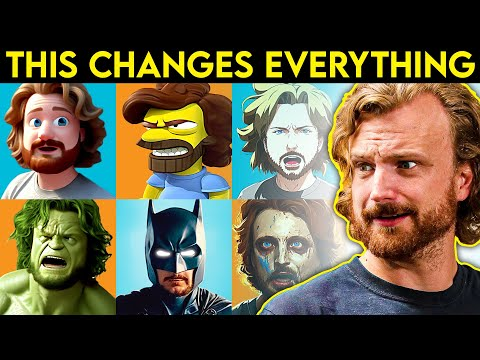

In [9]:
from IPython.display import YouTubeVideo

YouTubeVideo("W4Mcuh38wyM")

다음은 "Mr Potato Head" 라는 인기 어린이 장난감의 사진 5장을 학습한 예시입니다. [a model](https://huggingface.co/sd-dreambooth-library/mr-potato-head).

먼저 파이프라인을 로드합니다. 그러면 허브에서 모델 가중치 등이 다운로드됩니다. 한 줄 데모를 위해 몇 기가바이트의 데이터가 다운로드되므로 이 셀은 건너뛰고 예제 출력을 감상해도 좋습니다!

In [4]:
from diffusers import StableDiffusionPipeline

# Check out https://huggingface.co/sd-dreambooth-library for loads of models from the community
model_id = "sd-dreambooth-library/mr-potato-head"

# Load the pipeline
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(
    device
)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

파이프라인 로딩이 완료되면 다음을 사용하여 이미지를 생성할 수 있습니다:

  0%|          | 0/51 [00:00<?, ?it/s]

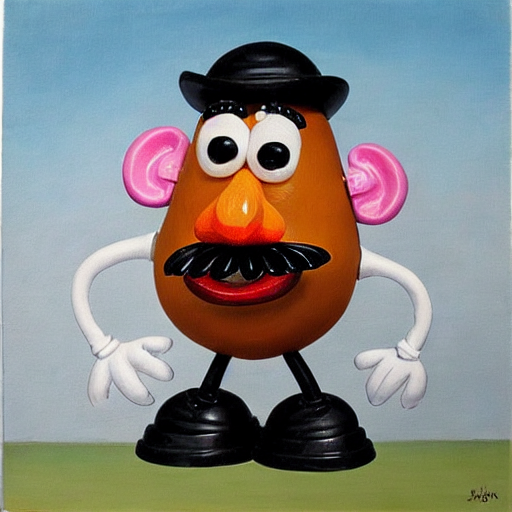

In [5]:
prompt = "an abstract oil painting of sks mr potato head by picasso"
image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]
image

**연습:** 다른 프롬포트로 직접 시도해보세요. 위 경우 `sks`토큰은 새로운 개념에 대한 고유 식별자를 나타냅니다. 이 토큰을 빼면 어떻게 될까요? 샘플링 단계 수(얼마나 낮출 수 있는가?)와 모델이 프롬프트와 일치하려고 시도하는 정도를 결정하는 `guidance_scale`을 변경하여 실험해 볼 수도 있습니다.

마법의 파이프라인에는 많은 일이 일어나고 있습니다! 이 과정이 끝나면 이 모든 것이 어떻게 작동하는지 알게 될 것입니다. 지금은 디퓨전 모델을 처음부터 훈련하는 방법을 살펴보겠습니다.

## MVP (Minimum Viable Pipeline)

🤗 디퓨저의 코어 API는 3개의 주요 구성요소로 나뉩니다:
1. **Pipelines**: 사용자 친화적인 방식으로 인기 있는 훈련된 디퓨전 모델에서 샘플을 빠르게 생성하도록 설계된 고급 클래스입니다.
2. **Models**: 새로운 디퓨전 모델 학습에 널리 사용되는 아키텍처입니다, *e.g.* [UNet](https://arxiv.org/abs/1505.04597).
3. **Schedulers**: *추론*과정에서 노이즈로부터 이미지를 생성하고 *학습*을 위해 노이즈 이미지를 생성하기 위한 다양한 기술을 제공합니다.

파이프라인은 최종 사용자에게 유용하지만, 이 강좌를 들으셨다면 내부에서 어떤 일이 벌어지는지 알고 싶으실 겁니다! 따라서 이 노트의 나머지 부분에서 작은 나비 그림을 생성할 수 있는 자체 파이프라인을 구축해 보겠습니다. 다음은 최종 결과물입니다:

C:\Users\warm1\anaconda3\envs\ml\lib\site-packages\huggingface_hub\file_download.py:129: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\warm1\.cache\huggingface\diffusers. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

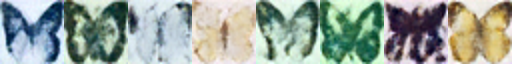

In [10]:
from diffusers import DDPMPipeline

# Load the butterfly pipeline
butterfly_pipeline = DDPMPipeline.from_pretrained(
    "johnowhitaker/ddpm-butterflies-32px"
).to(device)

# Create 8 images
images = butterfly_pipeline(batch_size=8).images

# View the result
make_grid(images)

드림부스 예제만큼 인상적이지는 않지만, 안정적 확산을 훈련하는 데 사용된 데이터의 0.0001%만 사용하여 처음부터 훈련하고 있습니다. 훈련에 대해 말하자면, 이 단원의 도입부에서 디퓨전 모델을 훈련하는 것이 다음과 같이 보인다는 것을 기억하세요:

1.   학습 데이터에서 일부 이미지 불러오기
2.   다양한 양의 노이즈를 추가하기
3.   노이즈가 있는 버전의 이미지를 모델에 입력
4.   모델이 이러한 입력 노이즈 제거를 얼마나 잘 수행하는지 평가
5.   이 정보를 사용하여 모델 가중치를 업데이트하고 반복

완전한 학습 루프가 작동할 때까지 다음 몇 섹션에서 이러한 단계를 하나씩 살펴본 다음, 학습된 모델에서 샘플링하는 방법과 쉽게 공유할 수 있도록 모든 것을 파이프라인으로 패키징하는 방법에 대해 알아보겠습니다. 데이터부터 시작하겠습니다...

## Step 2: Download a training dataset

이번 예제에서는 Hugging Face Hub의 이미지 데이터셋을 사용하겠습니다. 특별히, [this collection of 1000 butterfly pictures](https://huggingface.co/datasets/huggan/smithsonian_butterflies_subset)를 사용합니다. 이 데이터 세트는 매우 작은 데이터 세트이므로 몇 가지 더 큰 옵션에 대해 주석 처리된 줄도 포함했습니다. 자신만의 이미지 컬렉션을 사용하고 싶다면 주석 처리된 코드 예제를 사용하여 폴더에서 사진을 불러올 수도 있습니다.

In [11]:
import torchvision
from datasets import load_dataset
from torchvision import transforms

dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

# Or load images from a local folder
# dataset = load_dataset("imagefolder", data_dir="path/to/folder")

# We'll train on 32-pixel square images, but you can try larger sizes too
image_size = 32
# You can lower your batch size if you're running out of GPU memory
batch_size = 64

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

# Create a dataloader from the dataset to serve up the transformed images in batches
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to C:/Users/warm1/.cache/huggingface/datasets/huggan___parquet/huggan--smithsonian_butterflies_subset-7665b1021a37404c/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


이미지 배치를 가져와서 다음과 같이 이미지를 확인할 수 있습니다:

X shape: torch.Size([8, 3, 32, 32])


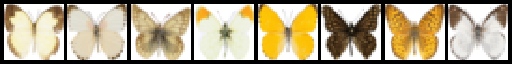

In [12]:
xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)

이 노트북에서는 학습 시간을 관리할 수 있도록 32픽셀 이미지로 구성된 작은 데이터 세트를 사용하고 있습니다.

## Step 3: Define the Scheduler

훈련 계획은 이러한 입력 이미지를 가져와 노이즈를 추가한 다음 노이즈가 있는 이미지를 모델에 공급하는 것입니다. 그리고 추론하는 동안 모델 예측을 사용하여 반복적으로 노이즈를 제거합니다. `디퓨저` 에서는 이 두 프로세스가 모두 **스케줄러**에 의해 처리됩니다. 

노이즈 스케줄은 다양한 시간 간격에 추가되는 노이즈의 양을 결정합니다. 'DDPM' 학습 및 샘플링에 대한 기본 설정을 사용하여 스케줄러를 생성하는 방법은 다음과 같습니다. (["Denoising Diffusion Probabalistic Models"](https://arxiv.org/abs/2006.11239):

In [13]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)


DDPM 문서에서는 모든 '타임스텝'마다 소량의 노이즈를 추가하는 손상 프로세스(corruption process)에 대해 설명합니다. $x_{t-1}$이 주어지면 다음(약간 더 노이즈가 많은) 버전$x_t$를 얻을 수 있습니다: <br><br>

$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$<br><br>


즉 우리는 $\sqrt{1 - \beta_t}$로 스케일링 된  $x_{t-1}$에 $\beta_t$ 로 스케일링 된 노이즈를 추가합니다. 이 $\beta$ 는 매 t마다 정의되며, 타임스텝당 얼마나 많은 노이즈가 추가되는지를 결정합니다. 이제 우리는 $x_{500}$ 를 구하기 위해 이 연산을 500번 할 필요는 없으므로 주어진 $x_0$에 대해 $x_t$를 구하는 다른 공식을 사용할 수 있습니다.: <br><br>

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, \sqrt{(1 - \bar{\alpha}_t)} \mathbf{I})
\end{aligned}$ where $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$ and $\alpha_i = 1-\beta_i$<br><br>

수학 표기법은 항상 무섭게 보입니다! 다행히 scheduler가 모든 것을 처리합니다(코드를 확인하려면 다음 셀의 주석처리를 해제하세요). 우리는 어떻게 입력 x와 노이즈가 타임스텝이 달라짐에 따라 섞이고 스케일링 되는지  $\sqrt{\bar{\alpha}_t}$ (`sqrt_alpha_prod`로 라벨링됨) 와 $\sqrt{(1 - \bar{\alpha}_t)}$ (`sqrt_one_minus_alpha_prod`로 라벨링됨) 의 그래프로 확인할 수 있습니다.:


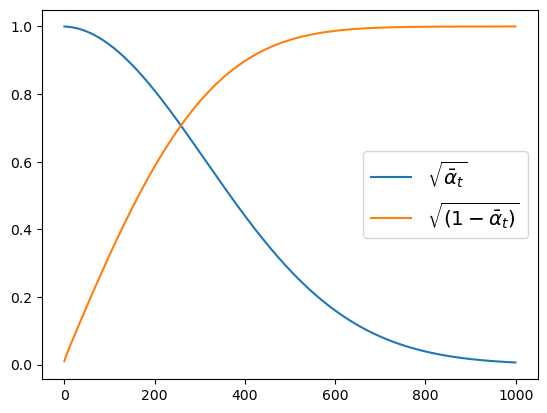

In [14]:
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

**연습:** beta_start, beta_end 와 beta_schedule 에 대한 다양한 설정에 따라 그래프가 어떻게 달라지는지 아래의 주석 옵션 중 하나를 교체하여 살펴볼 수 있습니다:

In [10]:
# One with too little noise added:
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.004)
# The 'cosine' schedule, which may be better for small image sizes:
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

어떤 스케줄러를 선택했든 이제 `noise_scheduler.add_noise` 함수를 사용하여 다음과 같이 다양한 양의 노이즈를 추가할 수 있습니다:

Noisy X shape torch.Size([8, 3, 32, 32])


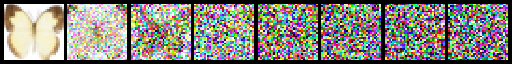

In [15]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)
show_images(noisy_xb).resize((8 * 64, 64), resample=Image.NEAREST)

여기에서 다양한 노이즈 스케줄과 매개 변수를 사용할 때의 효과를 다시 한 번 살펴보세요. [이 비디오](https://www.youtube.com/watch?v=fbLgFrlTnGU) 는 위의 수학 중 일부를 더 자세히 설명하고 있으며, 이러한 개념 중 일부를 소개하는 훌륭한 자료입니다. 

## Step 4: Define the Model

이제 핵심 구성 요소인 모델 자체에 대해 알아보겠습니다. 

대부분의 디퓨전 모델은 [U-net](https://arxiv.org/abs/1505.04597)의 일부 변형된 아키텍처를 사용하며 여기서는 아래의 아키텍처를 사용합니다.

![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/unet-model.png)

요약하자면:
- 모델은 입력 이미지가 여러 블록의 ResNet 레이어를 거치도록 하며, 각 레이어는 이미지 크기를 2만큼 절반으로 줄입니다.
- 그런 다음 같은 수의 블록을 통해 다시 업샘플링합니다.
- 다운샘플 경로의 피처를 업샘플 경로의 해당 레이어에 연결하는 스킵 연결이 있습니다. 

이 모델의 핵심 기능은 입력과 동일한 크기의 이미지를 예측한다는 것인데, 바로 여기에 필요한 것입니다. 

디퓨저는 파이토치에서 원하는 아키텍처를 생성하는 편리한 `UNet2DModel` 클래스를 제공합니다.

원하는 이미지 크기에 맞는 UNet을 만들어보겠습니다. 

`down_block_types`은 다운샘플링 블록(위 다이어그램의 녹색)에 해당하고, `up_block_types`는 업샘플링 블록(다이어그램의 빨간색)에 해당한다느 점에 유의하세요. 

In [16]:
from diffusers import UNet2DModel

# Create a model
model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device);

고해상도 입력을 처리할 때는 더 많은 다운 블록과 업 블록을 사용하고 어텐션 레이어는는 가장 낮은 해상도(하단) 레이어에만 유지하여 메모리 사용량을 줄일 수 있습니다. 사용 사례에 가장 적합한 설정을 찾기 위해 실험하는 방법에 대해서는 나중에 설명하겠습니다.

배치 데이터와 랜덤 타임스탭을 전달하면 입력 데이터와 동일한 형태의 출력이 생성되는 것을 확인할 수 있습니다.

In [17]:
with torch.no_grad():
    model_prediction = model(noisy_xb, timesteps).sample
model_prediction.shape

torch.Size([8, 3, 32, 32])

다음 섹션에서는 이 모델을 훈련하는 방법을 살펴보겠습니다.

## Step 5: Create a Training Loop

훈련할 시간입니다! 아래는 파이토치에서 데이터를 배치별로 실행하고 최적화 방법(이 경우 학습률이 0.0004인 AdamW 최적화 방법)을 사용하여 각 단계에서 모델의 파라미터를 업데이트하는 일반적인 최적화 과정입니다. 

각각의 배치 데이터에 대해서, 우리는
- 임의의 타임스텝 샘플
- 타임스텝에 따른 노이즈 제거
- 모델에 노이즈가 있는 데이터 입력 
- 평균 제곱 오차를 손실 함수로 사용하여 모델 예측을 대상(이 경우 노이즈)과 비교합니다.
- `loss.backward()` 와 `optimizer.step()` 를 통해 모델 매개변수를 업데이트합니다.

이 과정에서 나중에 플로팅을 위해 시간 경과에 따른 손실도 기록합니다.

참고: 이 코드는 실행하는 데 거의 10분이 걸리므로 바쁘다면 이 두 셀을 건너뛰고 사전 학습된 모델을 사용해도 됩니다. 또는 위의 모델 정의를 통해 각 레이어의 채널 수를 줄이면 작업 속도를 높일 수 있는 방법을 살펴볼 수도 있습니다.

[공식 디퓨저 학습 예시](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/training_example.ipynb)는 이 데이터 세트에 대해 더 큰 모델을 더 높은 해상도로 학습하며, 최소한의 학습 루프가 어떻게 생겼는지 배우기 위한 좋은 참고 자료입니다.

In [18]:
# Set the noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []

for epoch in range(30):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

Epoch:5, loss: 0.15221378207206726
Epoch:10, loss: 0.11680715857073665
Epoch:15, loss: 0.09752775775268674
Epoch:20, loss: 0.08175619645044208
Epoch:25, loss: 0.0821389255579561
Epoch:30, loss: 0.0776014314033091


손실을 플롯하면 모델이 초기에 빠르게 개선된 후 느린 속도로 계속 개선되는 것을 볼 수 있습니다(오른쪽에 표시된 것처럼 로그 스케일을 사용하면 더 명확하게 알 수 있습니다):

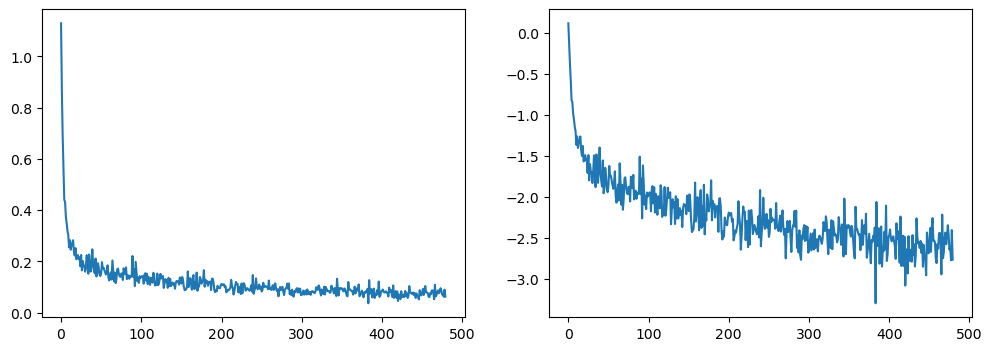

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

위의 학습 코드를 실행하는 대신 다음과 같이 파이프라인에서 모델을 사용할 수 있습니다:

In [20]:
# Uncomment to instead load the model I trained earlier:
# model = butterfly_pipeline.unet

## Step 6: Generate Images

이 모델로 이미지를 얻으려면 어떻게 해야 하나요?

### Option 1: Creating a pipeline:

In [21]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

  0%|          | 0/1000 [00:00<?, ?it/s]

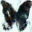

In [22]:
pipeline_output = image_pipe()
pipeline_output.images[0]

다음과 같이 파이프라인을 로컬 폴더에 저장할 수 있습니다:

In [23]:
image_pipe.save_pretrained("my_pipeline")

In [43]:
!dir "my_pipeline\" /b

model_index.json
scheduler
unet


`스케줄러` 및 `unet` 하위 폴더에는 이러한 구성 요소를 다시 생성하는 데 필요한 모든 것이 포함되어 있습니다. 예를 들어, `unet` 폴더 안에는 모델 가중치(`diffusion_pytorch_model.bin`)와 함께 UNet 아키텍처를 지정하는 구성 파일이 있습니다. 

In [44]:
!dir "my_pipeline\unet\" /b

config.json
diffusion_pytorch_model.bin


이 파일에는 파이프라인을 다시 만드는 데 필요한 모든 것이 포함되어 있습니다. 이러한 파일을 허브에 수동으로 업로드하여 다른 사람들과 파이프라인을 공유하거나 다음 섹션의 API를 통해 코드를 확인하여 공유할 수 있습니다.

### Option 2: Writing a Sampling Loop

파이프라인의 전달 메서드를 검사하면 `image_pipe()`를 실행할 때 어떤 일이 발생하는지 확인할 수 있습니다:

In [45]:
# ??image_pipe.forward

무작위 노이즈로 시작하여 가장 노이즈가 많은 단계부터 가장 적은 단계까지 스케줄러 시간 단계를 실행하여 모델 예측에 따라 각 단계에서 소량의 노이즈를 제거합니다:

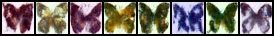

In [46]:
# Random starting point (8 random images):
sample = torch.randn(8, 3, 32, 32).to(device)

for i, t in enumerate(noise_scheduler.timesteps):

    # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample)

`noise_scheduler.step()` 함수는 `sample`을 적절하게 업데이트하는 데 필요한 수학을 수행합니다. 다음 단원에서는 다른 샘플러로 교체하여 기존 모델로 이미지 생성 속도를 높이는 방법을 살펴보고 확산 모델에서 샘플링하는 이론에 대해 자세히 설명하겠습니다.

## Step 7: Push your model to the Hub

위의 예제에서는 파이프라인을 로컬 폴더에 저장했습니다. 모델을 Hub로 푸시하려면 파일을 푸시할 모델 리포지토리가 필요합니다. 모델에 부여할 모델 ID에서 리포지토리 이름을 결정합니다(`model_name`을 원하는 이름으로 자유롭게 바꿀 수 있으며, `get_full_repo_name()` 함수가 수행하는 것처럼 사용자 이름만 포함하면 됩니다):

In [1]:
from huggingface_hub import get_full_repo_name

model_name = "sd-class-butterflies-32"
hub_model_id = get_full_repo_name(model_name)
hub_model_id

'lewtun/sd-class-butterflies-32'

그런 다음 🤗 허브에 모델 리포지토리를 만들고 모델을 푸시합니다:

In [22]:
from huggingface_hub import HfApi, create_repo

create_repo(hub_model_id)
api = HfApi()
api.upload_folder(
    folder_path="my_pipeline/scheduler", path_in_repo="", repo_id=hub_model_id
)
api.upload_folder(folder_path="my_pipeline/unet", path_in_repo="", repo_id=hub_model_id)
api.upload_file(
    path_or_fileobj="my_pipeline/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

'https://huggingface.co/lewtun/sd-class-butterflies-32/blob/main/model_index.json'

마지막으로 해야 할 일은 허브에서 나비 생성기를 쉽게 찾을 수 있도록 멋진 모델 카드를 만드는 것입니다(설명을 자유롭게 확장하고 편집하세요!):

In [ ]:
from huggingface_hub import ModelCard

content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Model Card for Unit 1 of the [Diffusion Models Class 🧨](https://github.com/huggingface/diffusion-models-class)

This model is a diffusion model for unconditional image generation of cute 🦋.

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
card.push_to_hub(hub_model_id)

이제 모델이 허브에 있으므로 다음과 같이 `DDPMPipeline`의 `from_pretrained()` 메서드를 사용하여 어디에서나 다운로드할 수 있습니다.

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

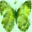

In [24]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline.from_pretrained(hub_model_id)
pipeline_output = image_pipe()
pipeline_output.images[0]

Great it works!

# Scaling up with 🤗 Accelerate

이 노트북은 학습용으로 만들었기 때문에 코드를 가능한 한 최소화하고 깔끔하게 유지하려고 노력했습니다. 따라서 멀티 GPU 지원, 진행 상황 및 예제 이미지 로깅, 더 큰 배치 크기를 지원하는 그라데이션 체크포인트, 모델 자동 업로드 등 훨씬 더 많은 데이터에 대해 더 큰 모델을 훈련할 때 필요한 몇 가지 기능을 생략했습니다. 다행히도 이러한 기능의 대부분은 예제 훈련 스크립트에서 사용할 수 있습니다. [here](https://github.com/huggingface/diffusers/raw/main/examples/unconditional_image_generation/train_unconditional.py).

다음과 같이 파일을 다운로드할 수 있습니다:

In [ ]:
!wget https://github.com/huggingface/diffusers/raw/main/examples/unconditional_image_generation/train_unconditional.py

파일을 열면 모델이 정의된 위치와 사용 가능한 설정을 확인할 수 있습니다. 다음 명령으로 스크립트를 실행했습니다:

In [8]:
# Let's give our new model a name for the Hub
model_name = "sd-class-butterflies-64"
hub_model_id = get_full_repo_name(model_name)
hub_model_id

'lewtun/sd-class-butterflies-64'

In [ ]:
!accelerate launch train_unconditional.py \
  --dataset_name="huggan/smithsonian_butterflies_subset" \
  --resolution=64 \
  --output_dir={model_name} \
  --train_batch_size=32 \
  --num_epochs=50 \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-4 \
  --lr_warmup_steps=500 \
  --mixed_precision="no"

이전과 마찬가지로 모델을 Hub로 푸시하고 멋진 모델 카드를 만들어 보겠습니다(원하는 대로 자유롭게 편집할 수 있습니다!):

In [14]:
create_repo(hub_model_id)
api = HfApi()
api.upload_folder(
    folder_path=f"{model_name}/scheduler", path_in_repo="", repo_id=hub_model_id
)
api.upload_folder(
    folder_path=f"{model_name}/unet", path_in_repo="", repo_id=hub_model_id
)
api.upload_file(
    path_or_fileobj=f"{model_name}/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Model Card for Unit 1 of the [Diffusion Models Class 🧨](https://github.com/huggingface/diffusion-models-class)

This model is a diffusion model for unconditional image generation of cute 🦋.

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
card.push_to_hub(hub_model_id)

'https://huggingface.co/lewtun/sd-class-butterflies-64/blob/main/README.md'

약 45분 후, 결과는 다음과 같습니다:

  0%|          | 0/1000 [00:00<?, ?it/s]

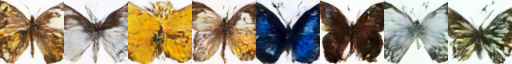

In [5]:
pipeline = DDPMPipeline.from_pretrained(hub_model_id).to(device)
images = pipeline(batch_size=8).images
make_grid(images)

**연습:** 가능한 한 짧은 시간에 좋은 결과를 얻을 수 있는 트레이닝/모델 설정을 찾을 수 있는지 확인하고, 그 결과를 커뮤니티와 공유하세요. 스크립트를 자세히 살펴보고 코드를 이해할 수 있는지 확인하고 혼란스러워 보이는 부분이 있으면 설명을 요청하세요.

# Avenues for Further Exploration

이를 통해 🤗 디퓨저 라이브러리로 무엇을 할 수 있는지 맛보셨기를 바랍니다! 다음 단계는 다음과 같습니다:

- 새 데이터 세트에서 무조건 확산 모델을 훈련해 보세요. 다음과 같은 경우 보너스 점수를 받을 수 있습니다. [create one yourself](https://huggingface.co/docs/datasets/image_dataset). 이 작업을 위한 몇 가지 훌륭한 이미지 데이터 세트는 Hub에 있는 [HugGan organization](https://huggingface.co/huggan) 에서 찾을 수 있습니다. 모델이 훈련할 때까지 오래 기다리지 않으려면 다운샘플링을 해야 합니다!
- 드림부스를 사용해 다음 중 하나를 사용하여 자신만의 맞춤형 Stable Diffusion 파이프라인을 만들어 보세요. [this Space](https://huggingface.co/spaces/multimodalart/dreambooth-training) or [this notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/sd_dreambooth_training.ipynb)
- 훈련 스크립트를 수정하여 다양한 UNet 하이퍼파라미터(레이어 수, 채널 수 등), 다양한 노이즈 스케줄 등을 탐색합니다.
-  [Diffusion Models from Scratch](https://github.com/huggingface/diffusion-models-class/blob/main/unit1/02_diffusion_models_from_scratch.ipynb) 노트북을 사용해 이 단원에서 다룬 핵심 아이디어를 다른 시각으로 살펴보세요.

행운을 빌며 2편도 기대해주세요!